<a href="https://colab.research.google.com/github/charles2secret/MobileNetV2-Model-for-Image-Classification/blob/main/Image_lassification_for_colorectal_cancer_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applying MobileNetV2 to colorectal cancer histology**

G3 presentation 

By Adria, Charles, Jennifer, Ryan

### **1. Introduction**




#### **1.1.Background**

According to [Cancer Facts and Statistics](https://www.cancer.org/research/cancer-facts-statistics.html), cancer is a disease characterized by the unchecked division of abnormal cells. When this type of growth occurs in the colon or rectum, it is called colorectal cancer (CRC). The colon and rectum (colorectum), along with the anus, make up the large intestine, the final segment of the gastrointestinal (GI) system. (Check the green part of Figure 1)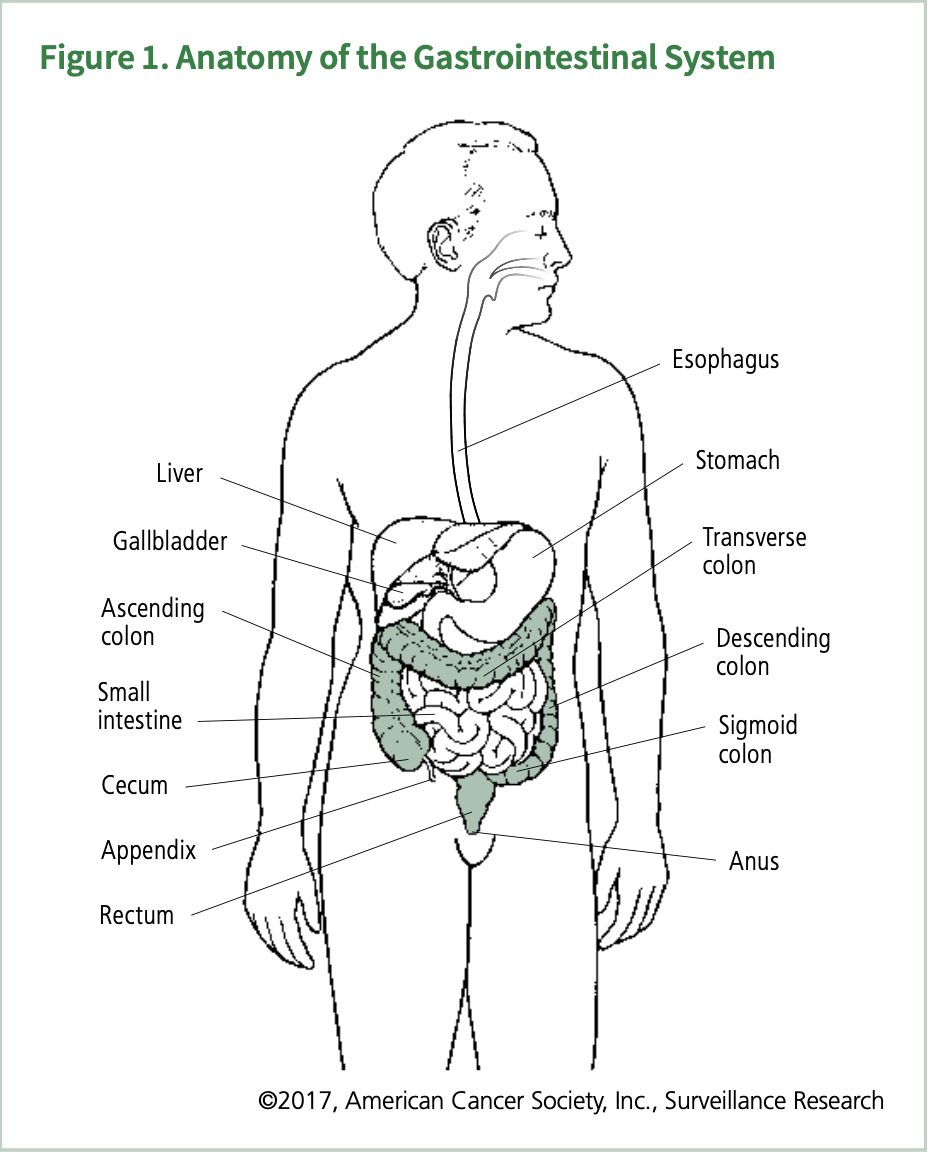

Furthermore, based on [Cancer.Net](https://www.cancer.net/cancer-types/colorectal-cancer/statistics), colorectal cancer happens to be the third most common cancer diagnosed in the United States. However, after tracing millions of cases, doctors found that the earlier the cancer has been diagnosed, the higher chance that patient will be cured. Given this fact, our group decided to delve into this topic and train a deep convolutional neural network (using MobileNet as a starting point) to detect the texture of colorectal cancer in order to help the hospital find it faster.



---
---



## **2.Preparations**



*   We import different layers, such as Dropout, MaxPooling2D and Conv2D, to make sure we can construct a satisfactory convolutional neural network which can serve as our simple CNN.
*   We import MobileNet and MobileNetV2 from applications to ensure we can use pretrained parameters and transfer learning to enhance our model. 
*   Finally, since we decide to use existed dataset colorectal_histology, we import tensorflow_datasets to download. 






In [ ]:
!pip install tf_keras_vis

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image

from tensorflow.keras import backend as K
from sklearn.manifold import TSNE
from collections import OrderedDict

from matplotlib import pyplot
import matplotlib.pylab as plt 
from scipy.signal import convolve2d
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import imagenet_utils,MobileNet,MobileNetV2
from tensorflow.keras.preprocessing import image
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

physical_devices = tf.config.experimental.list_physical_devices('GPU')
n_GPUs = len(physical_devices)
print("Num GPUs Available: ", n_GPUs)

name=["AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
    ]
classes_num=10
size=6000
seed=13
tf.random.set_seed(seed)


Num GPUs Available:  1


### **2.1.User-defined functions**



We wrote some functions in order to help ourselves analyze our models clearly and accurately. For example:

*  The function `img_aug` utilizes some important built-in functions in tf.image, which helps us complete data augmentation. 
*  The function `plot_hist` outputs loss and accuracy curve for both training and validation sets. The output plots help us visually understand the performance of our model as the epoch goes up. 
*  The function `visualize` is the most important feature in our program. It clearly and accuratly shows the visualization of different layers, for which we can see the difference as the layer goes deeper. Furthermore, it outputs predictions for randomly selected images from our dataset, so we can make sure our model really learns how to distinguish "tumor" from "debris" for example.   






In [ ]:
def preprocess(element):
  image=preprocess_input(tf.image.resize(element['image'],size=(160,160)))
  label=tf.one_hot(indices=element['label'],depth=classes_num)
  return image,label

def img_aug(element):
  img=element['image']
  lab=element['label']
  img=preprocess_input(tf.image.resize(img,size=(160,160)))
  lab=tf.one_hot(indices=lab,depth=classes_num)
  deg=int(np.random.choice([90,180,270]))
  rotimg=tf.image.rot90(img)
  if deg>90:
    rotimg=tf.image.rot90(rotimg)
  if deg>180:
    rotimg=tf.image.rot90(rotimg)
  rotimg=tf.image.random_flip_up_down(rotimg)
  rotimg=tf.image.random_flip_left_right(rotimg)
  return rotimg,lab

def plot_hist(hist):
  """
  To plot history of our model
  Argument:
  hist:An instance of history object.
  example:plot_hist(model.hist)
  """
  fig, axs = plt.subplots(1,2, figsize=(15,5))
  for i, to_plot in enumerate(['loss', 'accuracy']):
    axs[i].plot(hist.history[f'{to_plot}'], label='train')
    axs[i].plot(hist.history[f'val_{to_plot}'], label='test')
    axs[i].set_ylabel(to_plot)
    axs[i].set_xlabel('epoch')
    axs[i].legend()

def eval_model(model, X_train, X_test, y_train, y_test):
  """
  To evaluate model
  Plot the train and test accuracy.
  
  """
  _, train_acc = model.evaluate(X_train, y_train, verbose=0)
  _, test_acc = model.evaluate(X_test, y_test, verbose=0)
  print('Accuracies\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))

def get_feature_maps(model, layer_id, input_image):
    """
    Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

def model_modifier(m):
    m.layers[-1].activation=tf.keras.activations.linear
    return m

def visualize(model,layers=[5,17],sample_size=5):
  """
  Show the visualization of the model
  Args:
  model:the model to visualize
  sample_size:how many images for test
  layers:list which layers output to show
  """
  tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Supress the possible warnings in the loop
  sample=_data.take(sample_size)
  fig,ax=plt.subplots(4+len(layers),sample_size,figsize=(20,20))
  column=0
  for element in sample:
    image=preprocess_input(tf.image.resize(element['image'],size=(160,160)))
    predictions=model.predict(np.expand_dims(image,axis=0))
    pred_id=np.argmax(predictions)
    saliency=Saliency(model,model_modifier)
    newloss=lambda output: tf.keras.backend.mean(output[:,pred_id])
    saliency_map=saliency(newloss,image,smooth_samples=20,smooth_noise=0.20)
    saliency_map=normalize(saliency_map)
    feature_maps=[]
    for num in layers:
      feature_maps.append(get_feature_maps(model,num,image)[0])
    pre_class=name[np.argmax(predictions)]
    ax[0][column].imshow(element['image'])
    ax[0][column].set_title(f'{pre_class}({np.argmax(predictions)})')
    ax[0][column].axis(False)
    ax[1][column].imshow(np.clip(image,0,1))
    ax[1][column].set_title('Processed')
    ax[1][column].axis(False)
    ax[2][column].bar(x=np.array(range(classes_num)),height=predictions.reshape(classes_num))
    for i in range(len(layers)):
      ax[3+i][column].imshow(feature_maps[i],cmap='gray')
      ax[3+i][column].axis(False)
      ax[3+i][column].set_title(f'Out put of layer {layers[i]}')
    ax[3+len(layers)][column].imshow(saliency_map[0], cmap='afmhot')
    ax[3+len(layers)][column].set_title("Saliency Map")
    column+=1
    

We use the T-SNE algorithm to visualize the Nerual Networks classification process. It can help us better understand the working process of the Nerual Networks. Following are the functions about T-SNE.


*   The function `tsne_data` process the data into the format required by the T-SNE algorithm.This function splits the data in the dataset into two parts `test_data_array` and `test_data_labels` as `np.array` and `list`. It can also choose whether the output `test_data_array` is flattened according to the needs of the subsequent function
*   The function `plot_tsne` is to plot the T-SNE embedding results of a particular dataset.
*   The function `model_plot_tsne` is to plot the T-SNE embedding results of the specified layer of the model. The main difference between `model_plot_tsne` and `plot_tsne` is that `model_plot_tsne` can output multiple images, which is helpful to show the dynamic process of image classification in the model.
*   The function `model_tsne` is to generate a map(`np.array`) based on built-in functions in `sklearn.manifold`, and call the function `model_plot_tsne` to display it.

In [ ]:
def tsne_data(dataset):
  '''
  Process the data into the format required by the T-SNE algorithm.
  Parameters:
      dataset(DatasetV1Adapter): the dataset to be used.
  Returns:
      test_data_array(np.array): processed data without each image flattened.
      test_data_array_flatten(np.array): processed data with each image flattened.
      test_data_labels(list): the labels of the dataset.
  '''
  test_data_numpy = tfds.as_numpy(dataset)  # Convert `tf.data.Dataset` to Python generator
  test_data_array,test_data_array_flatten,test_data_labels_numpy = [],[],[]
  for ex in test_data_numpy:
    # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
    test_data_array.append(np.array(ex[0]))
    test_data_array_flatten.append(np.array(ex[0].flatten()))
    test_data_labels_numpy.append(np.array(ex[1]))
    #print(type(ex[0]))

  test_data_array = np.array(test_data_array)
  test_data_array_flatten = np.array(test_data_array_flatten)
  test_data_labels_numpy = np.array(test_data_labels_numpy)

  test_data_labels = []
  for element in test_data_labels_numpy:
    for i in range(classes_num):
      if element[i]==1: test_data_labels.append(i)
  test_data_labels=np.array(test_data_labels)
  
  return test_data_array,test_data_array_flatten,test_data_labels

def plot_tsne(result, test_label, title): 
  '''
  To plot the T-SNE embedding results a single scatter diagram.
  Args:
      result(np.array)：embedding of the data in low-dimensional space.
      test_label(list)：the labels of the dataset.
      title（str)：the title of the plot.  
  '''   
  x_min, x_max = np.min(result, 0), np.max(result, 0)
  data = (result - x_min) / (x_max - x_min) 
  plt.figure(figsize=(8,8))
  for i in range(data.shape[0]):

    plt.scatter(data[i, 0], data[i, 1], label=name[test_label[i]], 
                c=plt.cm.Set1(test_label[i]/10.),edgecolors='none')
  handles, labels = plt.gca().get_legend_handles_labels()
  by_label = OrderedDict(zip(labels, handles))
  plt.legend(by_label.values(), by_label.keys())
  plt.title(title)
  plt.show()

def model_plot_tsne(tsne_list, test_label, title,output_layers):  
  '''
  To plot the T-SNE embedding results of the specified layer of the model.
  Args:
      tsne_list(list):list of embedding of the data in low-dimensional space.
      test_label(list):the labels of the dataset.
      title(str):the title of the plot.
      output_layers(list):list of the depth of the layers to output the T-SNE results.
  ''' 
  fig,ax=plt.subplots(1,len(tsne_list),figsize=(20,5))
  n=0
  for data in tsne_list:
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min) 
    for i in range(data.shape[0]):
        ax[n].scatter(data[i, 0], data[i, 1], label=name[test_label[i]], 
                    c=plt.cm.Set1(test_label[i]/10.),edgecolors='none')
    if n<len(tsne_list)-1:
      #ax[n].set_title('the T-SNE of the %d layer' %output_layer[n])
      ax[n].set_title('the T-SNE of the %d layer' %output_layers[n])
    else:
      ax[n].set_title('the T-SNE of the output layer')
    n+=1
  handles, labels = plt.gca().get_legend_handles_labels()
  by_label = OrderedDict(zip(labels, handles))
  fig.legend(by_label.values(), by_label.keys())
  fig.show()

def model_tsne(model,output_layers,output_final=-1):
  '''
  To visualize the specified layer of the specified model by T-SNE algorithm.
  Args:
    model(tf.keras.Model): Model to visualize.
    output_layers(list[int,int,int]): you can decide which 3 layers to visualize.
    output_final(int): T-SNE result of the final output of the model.
  '''
  test_data_array,_,test_data_labels = tsne_data(data_aug.take(640))
  tensor_list,tsne_list=[],[]

  for output_layer in output_layers:
    intermed_tensor_func=K.function([model.layers[0].input],[model.layers[output_layer].output])
    intermed_tensor=intermed_tensor_func(test_data_array)[0]
    l=[]
    for ele in intermed_tensor:
      l.append(ele.flatten())
    intermed_tensor=np.array(l)
    #print(intermed_tensor.shape)
    tensor_list.append(intermed_tensor)

  output_tensor_func=K.function([model.layers[0].input],[model.layers[-1].output])
  output_tensor=output_tensor_func(test_data_array)[0]
  tensor_list.append(output_tensor)

  tsne=TSNE(n_components=2,init='pca',random_state=1000)

  for i in range(len(tensor_list)):
    intermed_tsne=tsne.fit_transform(tensor_list[i])
    tsne_list.append(intermed_tsne)
  
  #intermed_tsne=tsne.fit_transform(intermed_tensor)
  model_plot_tsne(tsne_list, test_data_labels,"t-sne",output_layers)



---



### **2.2.Data Processing**

We load the data from tf.dataset with our designated seed in order to ensure we can reload the notebook without changing the output.
In addition, from the features dictionary, we can see that our images are all RGB with 150X150 in size, and there are total of 8 classes to classify.

In [ ]:
_data,info=tfds.load(name='eurosat',with_info=True,shuffle_files=True)
_data=_data['train']
_data=_data.shuffle(size,seed=seed)
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

**Let's take a look at some examples from the dataset**

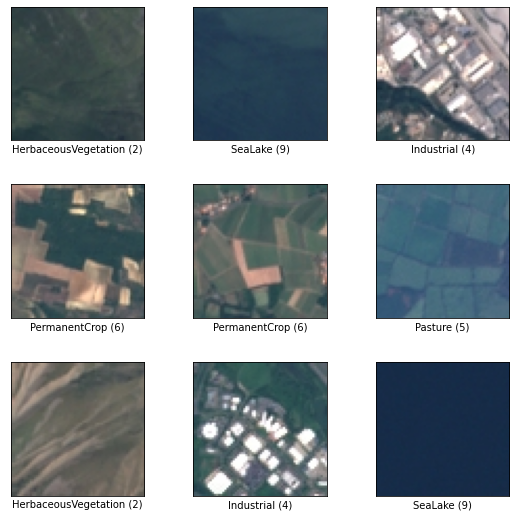

In [ ]:
tfds.show_examples(_data,info,rows=3,cols=3);

**For input we need to preprocess the image**

As we mentioned above, we preprocessed our data using data augmentation to reduce overfitting problem.

In [ ]:
data=_data.map(preprocess)
data_aug=_data.map(img_aug)

# data=data.concatenate(data_aug)

test_data=data.take(int(size/3))
train_data=data.skip(int(size/3))

**T-SNE result of the dataset**

By using TSNE function as we described above, we are able to visualize the distribution of all 8 classes. 

In [ ]:
_,test_data_array,test_data_labels = tsne_data(test_data)

pca_tsne = TSNE(n_components=2, init='pca', random_state=0)
newMat = pca_tsne.fit_transform(test_data_array)

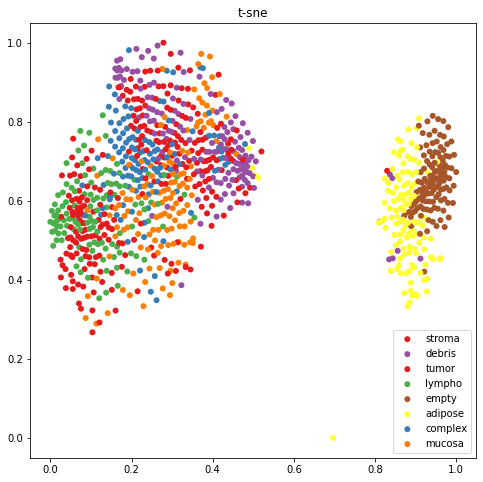

In [ ]:
plot_tsne(newMat, test_data_labels,"t-sne")

It is easy to see that except "adipose" and "empty", all six other classes are clustered together. The main goal for our model is to seperate all 8 classes and distinguish them.



---



---



## **3.Neural Networks**

#### **3.1.Simple CNN**

This is a simple convolutional neural network we build for this task and as a comparison to MobileNet. For this simple CNN, we include 4 convolutional layers with same padding and relu activation, one maxpooling layer, and a dropout layer to avoid overfitting. 


**traditional convolutions**

The traditional convolutional network is cross-channel. For an input FeatureMap with the number of M channels, we need to get the output FeatureMap with the number of N channels.

The number of parameters of traditional convolution is:
$$D_{K} \times D_{K} \times M \times N$$

 The computational cost of its one-layer network is about:

$$D_{K} \times D_{K} \times M \times N \times D_{W} \times D_{H}$$


Obviously, as a cross-channel convolution, traditional convolution has the problem of excessively high number of parameters and high computational cost.To solve this problem, MobileNet uses Depthwise separable convolutions. We will discuss it later.

In [ ]:
simple = Sequential(name = 'Simple_CNN')
simple.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(160, 160, 3)))
simple.add(MaxPooling2D((2, 2), padding = 'same'))
simple.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
simple.add(MaxPooling2D((2, 2), padding = 'same'))
simple.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
simple.add(MaxPooling2D((2, 2)))
simple.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
simple.add(MaxPooling2D((2, 2)))
simple.add(Flatten())
simple.add(Dropout(0.15))
simple.add(Dense(32, activation='relu'))
simple.add(Dense(classes_num, activation='softmax'))

simple.summary()

simple.compile(optimizer = Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "Simple_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       1

In [ ]:
x_train=train_data.batch(64).prefetch(3)
x_val=test_data.batch(64).prefetch(3)
simple.fit(x=x_train,validation_data=x_val,epochs=50,shuffle=True)

Epoch 1/50
  2/391 [..............................] - ETA: 30s - loss: 0.5632 - accuracy: 0.8047WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0270s vs `on_train_batch_end` time: 0.0612s). Check your callbacks.


391/391 [==============================] - 31s 78ms/step - loss: 0.4581 - accuracy: 0.8427 - val_loss: 0.4122 - val_accuracy: 0.8525
Epoch 2/50
391/391 [==============================] - 31s 78ms/step - loss: 0.3531 - accuracy: 0.8797 - val_loss: 0.3316 - val_accuracy: 0.8810
Epoch 3/50
391/391 [==============================] - 31s 78ms/step - loss: 0.2830 - accuracy: 0.9019 - val_loss: 0.2028 - val_accuracy: 0.9270
Epoch 4/50
391/391 [==============================] - 31s 78ms/step - loss: 0.2279 - accuracy: 0.9209 - val_loss: 0.2122 - val_accuracy: 0.9285
Epoch 5/50
391/391 [==============================] - 31s 78ms/step - loss: 0.1952 - accuracy: 0.9324 - val_loss: 0.1688 - val_accuracy: 0.9360
Epoch 6/50
391/391 [==============================] - 31s 78ms/step - loss: 0.1596 - accuracy: 0.9463 - val_loss: 0.1366 - val_accuracy: 0.9520
Epoch 7/50
391/391 [==============================] - 31s 78ms/step - loss: 0.1387 - accuracy: 0.9519 - val_loss: 0.1439 - val_accuracy: 0.9520
Epo

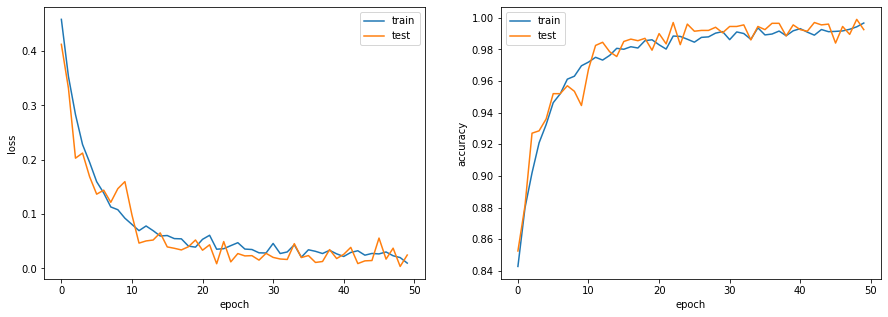

In [ ]:
plot_hist(simple.history)
simple.save('simple.hdf5')

In [ ]:
simple.evaluate(data_aug.batch(64).prefetch(3))

422/422 [==============================] - 47s 111ms/step - loss: 0.9002 - accuracy: 0.8711


[0.9001973867416382, 0.8711110949516296]

We can see that it takes about 40 epochs for the simplenet to achieve 0.99 val_acc, but the accuracy on test set is much lower.



---



#### **3.2.Pre-Trained Model Using MobileNetV1**

While reading the paper *MobileNetV2: Inverted Residuals and Linear Bottlenecks*, we found:

*'Our network design is based on MobileNetV1. It retains its simplicity and does not require any special operators while significantly improves its accuracy, achieving state of the art on multiple image classification and detection tasks for mobile applications.'*


Therefore, **before discussing MobileNetV2**, we first studied MobileNetV1 and trained MobileNetV1 with `x_train`. We believe that comparative learning of MobileNetV1 can help us better understanding the stucture and advantages of MbileNetV2.

The MobileNetV1 structure is built on depthwise separable convolutions as mentioned in the previous section except for the first layer which is a full convolution.

**3.2.1.Depthwise separable convolution**


***Depthwise convolution***

 depthwise convolution refers to convolution that does not cross channels, which means that each channel of feature map has an independent convolution kernel, and this convolution kernel functions and only acts on this channel. Its calculation cost is also the traditional convolution $\frac{1}{N}$ as:
$$D_{K} \times D_{K} \times M \times D_{W} \times D_{H}$$

***Pointwise convolution***

 Although the operation of Depthwise convolution is very efficient, it is only equivalent to applying a filter to a channel of the current FeatureMap, and will not merge several features to generate new features, and because the FeatureMap is output in the Depthwise convolution The number of channels is equal to the number of channels input to FeatureMap, so it does not have the function of dimensionality increase or dimensionality reduction.
 
In order to solve these problems, Pointwise convolution is introduced in v1 for feature merging and dimensionality up or down. Naturally, we can think of using $1 \times 1$ convolution to complete this function. The number of parameters of Pointwise is $M \times N$, and the amount of calculation is:
$$M \times N \times D_{W} \times D_{H}$$

***Depthwise Separable convolution*** 

Depthwise Separable convolution is a set of operations obtained by combining a 3 × 3 Depthwise convolution and a Pointwise convolution. Compared with a 3 × 3  convolution, the parameter amount and calculation cost of MobileNetV1 are about the $\frac{1}{8}$  of ordinary convolution.





**3.2.2.Model Architecture**

The MobileNetV1 structure is built on depthwise separable
convolutions as mentioned in the previous section except for
the first layer which is a full convolution.It has 28 layers. All layers are followed by a batchnorm and ReLU nonlinearity with the exception of the final fully connected layer which has no nonlinearity and feeds into a softmax layer for classification.

Although MobileNetV1 looks perfect, it still has some problems. For example, vanishing gradient problem. To solve this problem, MobileNetV2 was mentioned. We will explore this in depth later.

In [ ]:
dropout=0.1
head=MobileNet(input_shape=(160,160,3),include_top=False,weights='imagenet',pooling='max',classes=classes_num)
x=head.output
x=Dense(128)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(dropout)(x)
x=Dense(64)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(dropout)(x)
output=Dense(classes_num,activation='softmax')(x)
mobileNet=Model(head.input,output)

for layer in head.layers:
    layer.trainable = False

mobileNet.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

mobileNet.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_______________________________________________________

In [ ]:
x_train=train_data.batch(64).prefetch(3)
x_val=test_data.batch(64).prefetch(3)
mobileNet.fit(x=x_train,validation_data=x_val,epochs=10,shuffle=True)

Epoch 1/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3555 - accuracy: 0.8943 - val_loss: 0.2318 - val_accuracy: 0.9150
Epoch 2/10
391/391 [==============================] - 24s 62ms/step - loss: 0.1747 - accuracy: 0.9412 - val_loss: 0.1493 - val_accuracy: 0.9520
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.1311 - accuracy: 0.9549 - val_loss: 0.1282 - val_accuracy: 0.9535
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.1069 - accuracy: 0.9646 - val_loss: 0.0861 - val_accuracy: 0.9725
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.0862 - accuracy: 0.9713 - val_loss: 0.1111 - val_accuracy: 0.9650
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.0731 - accuracy: 0.9754 - val_loss: 0.0817 - val_accuracy: 0.9715
Epoch 7/10
391/391 [==============================] - 24s 60ms/step - loss: 0.0589 - accuracy: 0.9790 - val_loss: 0.0665 - val_accuracy:

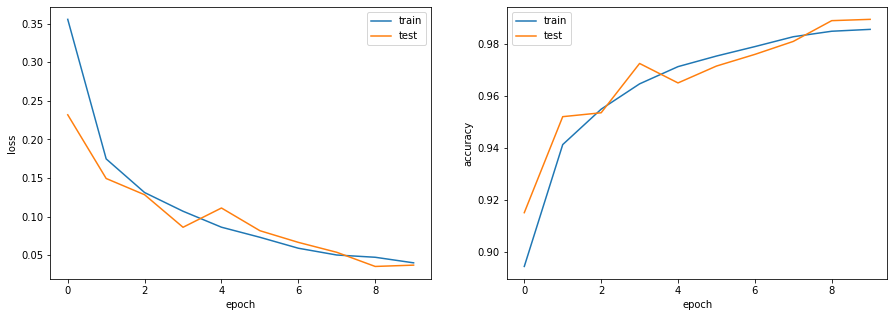

In [ ]:
plot_hist(mobileNet.history)
mobileNet.save('mobilenetV1.hdf5')

In [ ]:
mobileNet.evaluate(data_aug.batch(64).prefetch(3))

422/422 [==============================] - 45s 107ms/step - loss: 0.2336 - accuracy: 0.9395


[0.23361283540725708, 0.9395185112953186]

Using transfer learning, the mobilenet can easily achieve 0.99 val_accuracy in only 10 epochs, and achieve a fairly high accuracy in the test set (with data augmentation).



---



#### **3.3.Pre-Trained Model Using MobileNetV2**

**3.3.1.Differences between  MobileNetV1 and  MobileNetV2**

MbileNetV2 design is based on MobileNetV1. It retains its simplicity and does not require any special operators while significantly improves its accuracy. Here two main differences between MbileNetV1 and MbileNetV2.

*   Linear Bottlenecks:Some information will be lost when passing through Relu especially when it's low-dimensional, so to keep the information, we remove non-linearity in the bottlenecks.

*   Inverted Residual:Inspired by the intuition that the bottlenecks
actually contain all the necessary information, while an expansion layer acts merely as an implementation detail that accompanies a non-linear transformation of the tensor, we use shortcuts directly between the bottlenecks.

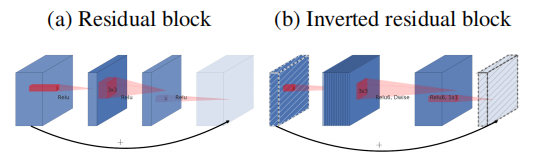

**3.3.2.Model Architecture**

This module takes as an input a low-dimensional compressed representation which is first expanded to high dimension and filtered with a lightweight depthwise convolution. Features are subsequently projected back to a low-dimensional representation with a linear convolution.And it's highly lightweight so that it can be implemented on mobile and embedded applications. 
>
Also, like MobileNetV1, V2 uses Depthwise Separable Convolutions to reduce computation. The difference, or improvement that V2 has lies in the bottleneck convolutions.

> 
V2 uses `inverted residuals` and `linear bottleneck` layers to prevent from destroying too much information caused by `Relu` activation function. The `linear bottleneck` layers are inserted into the concolutional blocks.

We have tested some structures, like freezing different layers, setting different `dropout` ratio, and we finally found that it would be better if we keep the `head` non-trainable and set `dropout`=0.1. We believe this is because the `head` has learned the skills to extract basic fatures like the textures. So what we need to do is only further process these features from `head` to get results. That is the idea of transfer learning.


```
freeze different layers to compare their performance 

freeze_layer_start=10
freeze_layer_end=17
for layer in head.layers[freeze_layer_start:freeze_layer_end]:
  layer.trainable=False
```



In [ ]:
dropout=0.1
head=MobileNetV2(input_shape=(160,160,3),include_top=False,weights='imagenet',pooling='max',classes=classes_num)
x=head.output
x=Dense(128)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(dropout)(x)
x=Dense(64)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(dropout)(x)
output=Dense(classes_num,activation='softmax')(x)
model=Model(head.input,output)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# freeze different layers to compare their performance 

# freeze_layer_start=10
# freeze_layer_end=17
# for layer in head.layers[freeze_layer_start:freeze_layer_end]:
#   layer.trainable=False

for layer in head.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
x_train=train_data.batch(64).prefetch(3)
x_val=test_data.batch(64).prefetch(3)
model.fit(x=x_train,validation_data=x_val,epochs=10,shuffle=True)

NameError: ignored

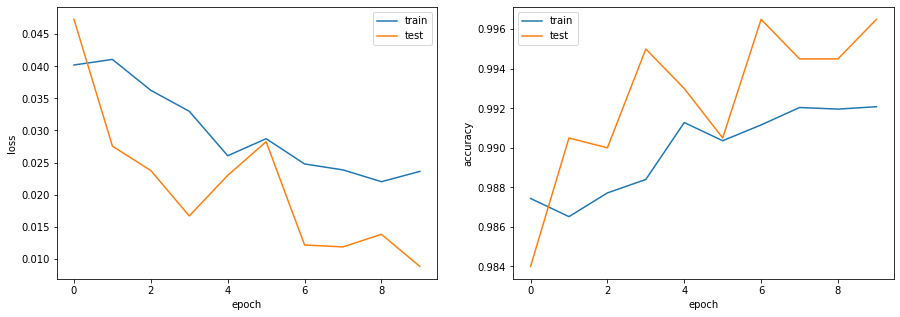

In [ ]:
plot_hist(model.history)
model.save('model.h5')

In [ ]:
model.evaluate(data_aug.batch(64).prefetch(3))


422/422 [==============================] - 46s 109ms/step - loss: 0.3325 - accuracy: 0.9335


[0.3324914574623108, 0.9335185289382935]

Similarly, the MobileNetV2's weights help the model achieve 0.99 val_accuracy very quickly(in 10 epochs). And it has slightly higher accuracy on test set than mobilenetV1.



---



---



## **4.Visualizations**

#### **4.1.Saliency maps**

Here we can see how confident our models are for their classification and how the input is processed through layers. We can know how the features are extracted by these neural networks and make a comparison.

**4.1.1.Saliency maps of Simple CNN**

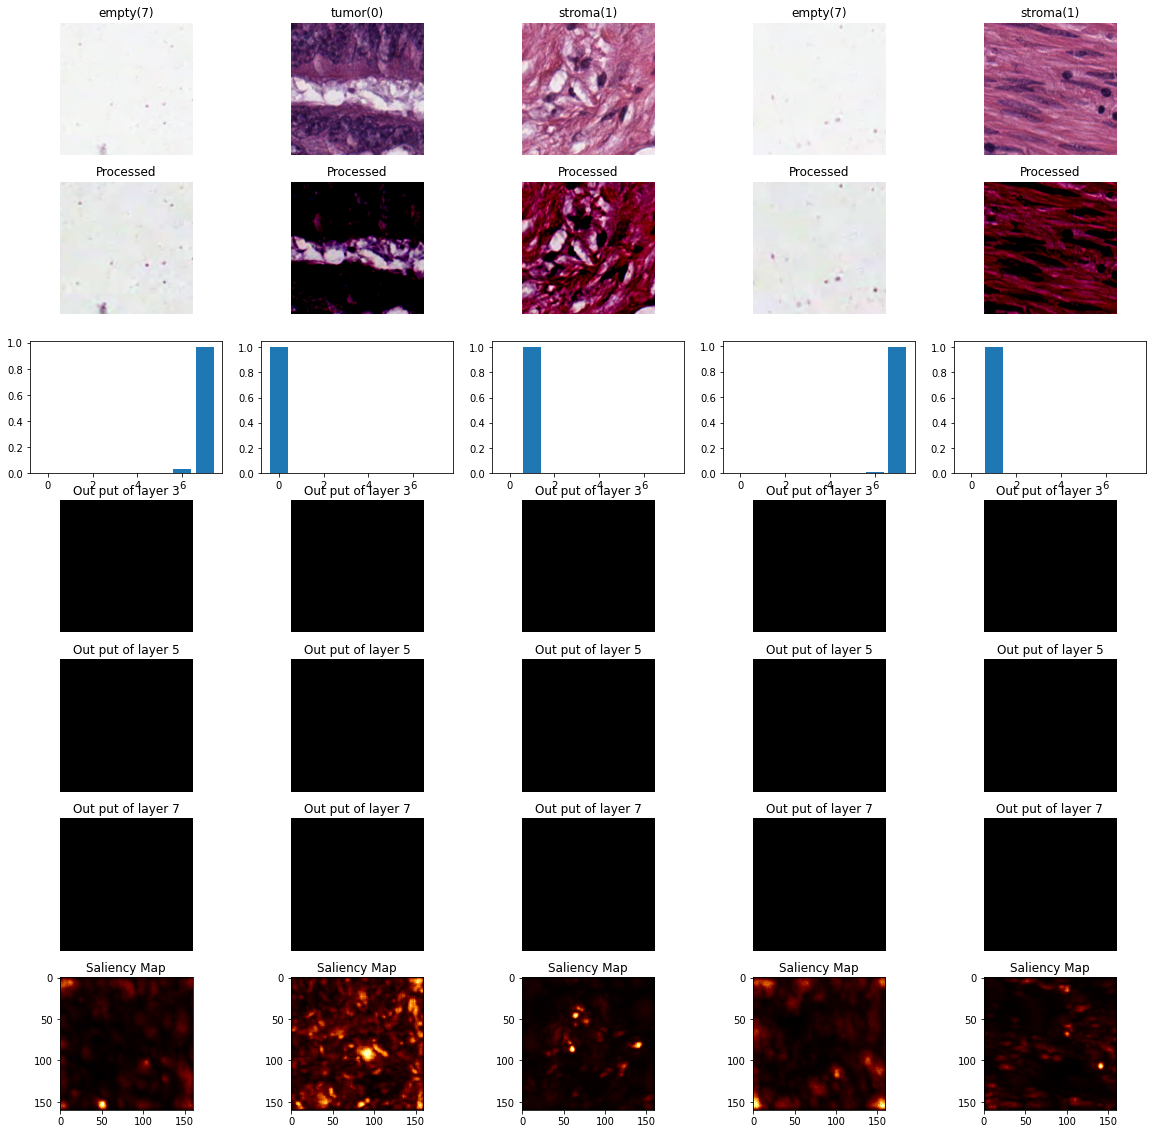

In [ ]:
visualize(simple,[3,5,7])

**4.1.2.Saliency maps of MobileNetV1**

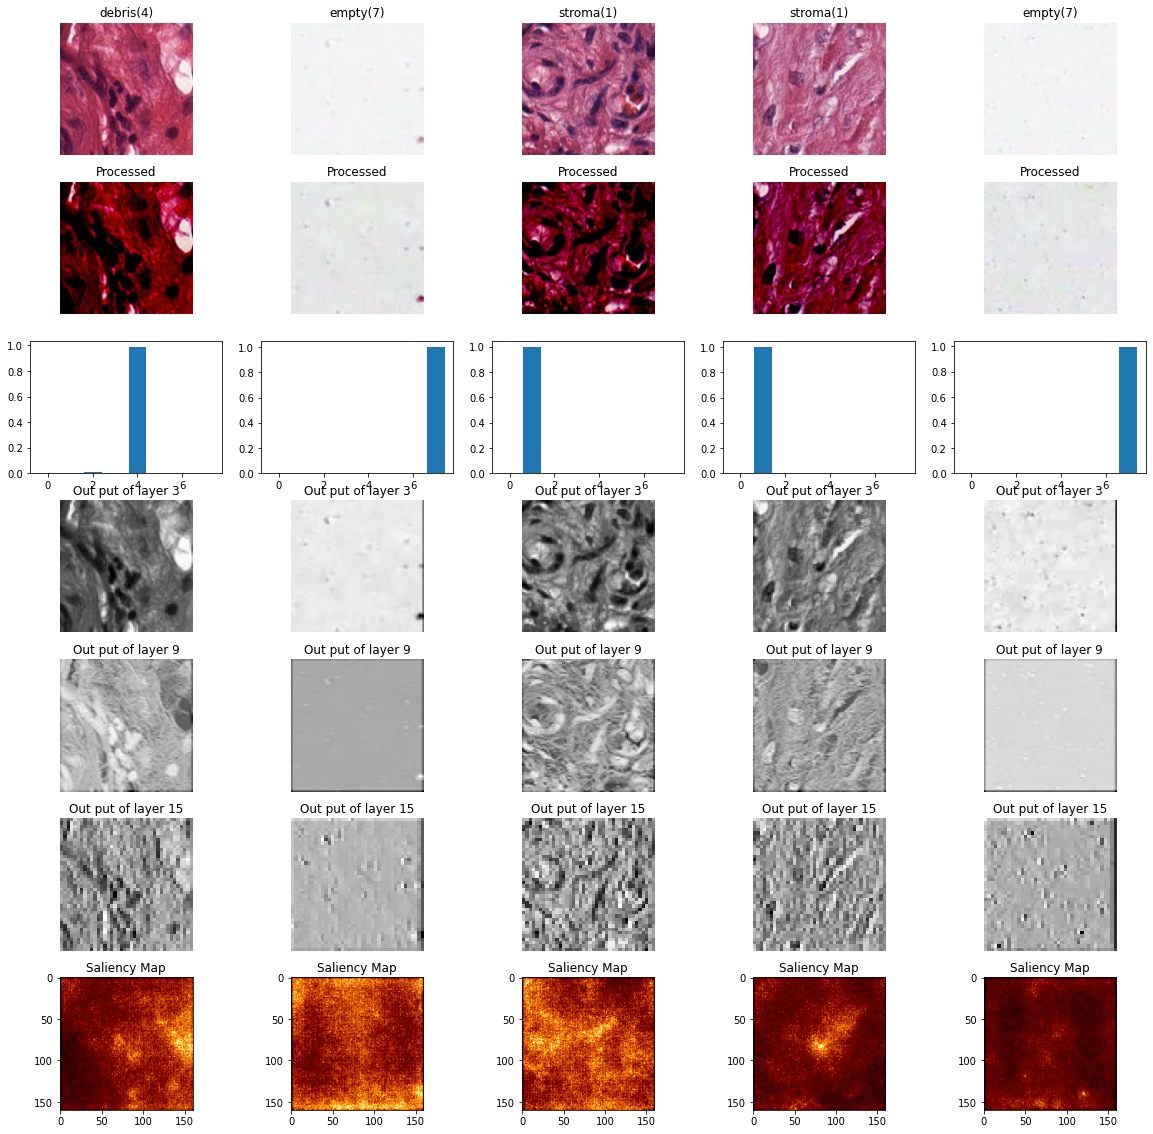

In [ ]:
visualize(mobileNet,[3,9,15])

**4.1.3.Saliency maps of MobileNetV2**

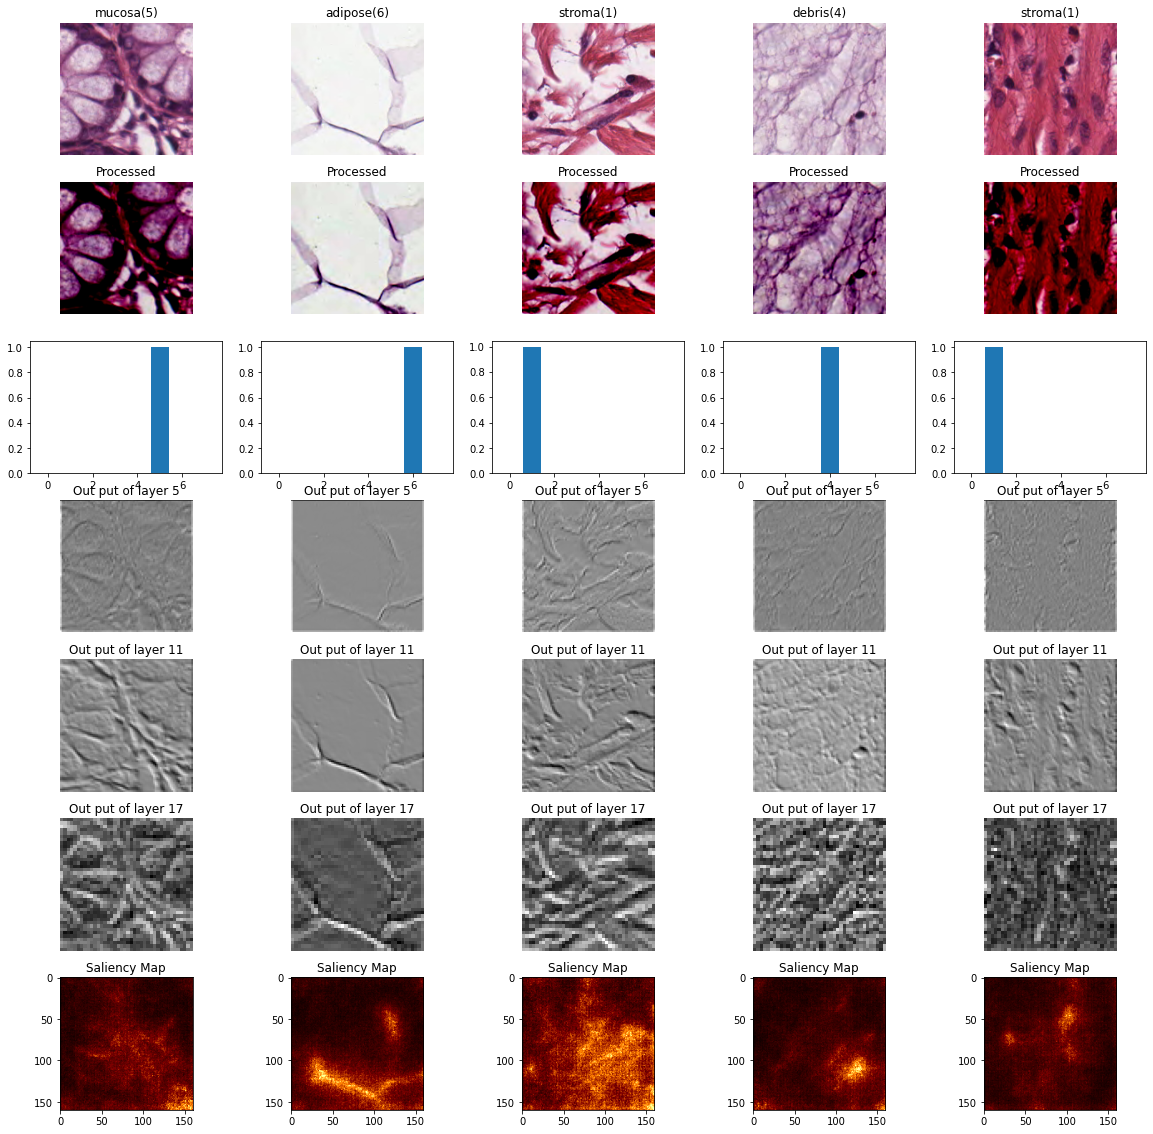

In [ ]:
visualize(model,[5,11,17])

From the visualization of the models, we can see the outputs from mobilenet(v1 & v2) are highly hierarchical. The network learns the features step by step through layers in contrast to the simplenet.



---



####**4.2.T-SNE**

t-SNE (t-distributed stochastic neighbor embedding) is a machine learning algorithm for dimensionality reduction, which was proposed by LaurensvanderMaaten and GeoffreyHinton in 2008. In addition, t-SNE is a nonlinear dimensionality reduction algorithm, which is very suitable for dimensionality reduction of high-dimensional data to 2 or 3 dimensions for visualization.

We visualize the output results of some typical layers in each model through T-SNE, and show the results below. These plots can help us observe the classification result of the test set through each layer of the neural network clearly.

**4.2.1.T-SNE of Simple CNN**

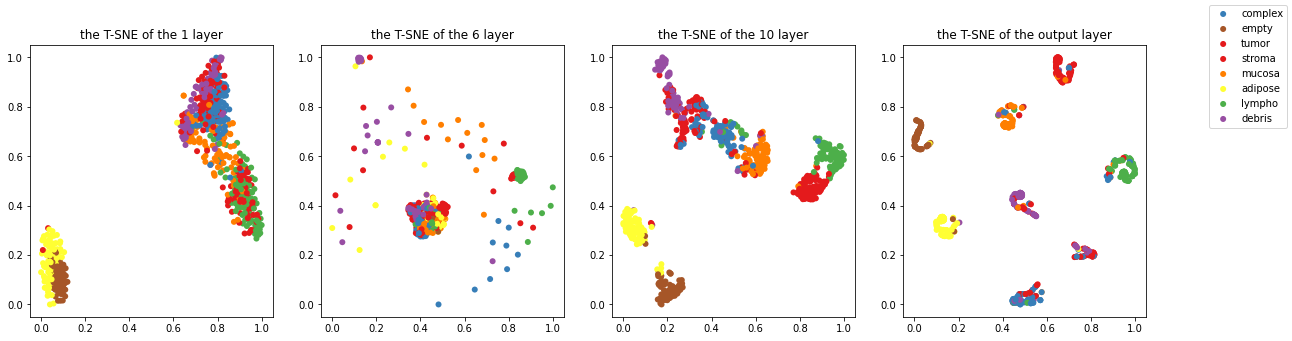

In [ ]:
model_tsne(simple,[1,6,10])

**4.2.2.T-SNE of MobileNetV1**

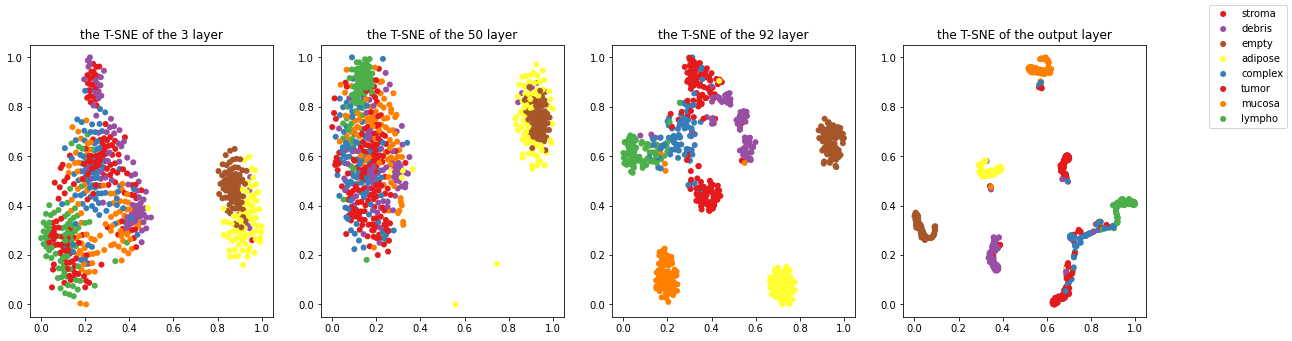

In [ ]:
model_tsne(mobileNet,[3,50,92])

**4.2.3.T-SNE of MobileNetV2**

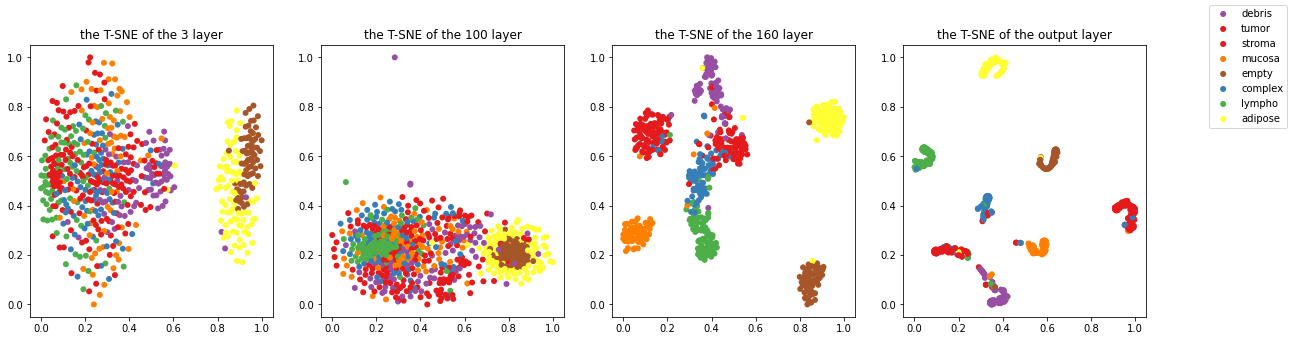

In [ ]:
model_tsne(model,[3,100,160])



---



---



## **5.Comparison and Conclusion**




#### **5.1 Comparison**

**5.5.1. Comparision of Simple CNN, MobieNetV1 and MobieNetV1**

The table below shows the comparison of the experimental data of the three models mentioned above.


|Model             ||Training Time||Training Time per Step||Validation Accuracy||Test Set Accuracy||Total Layers||Total params(millions)|
|------------------||-------------------||-------------------||-------------------||-------------------||---------||---------|
|Simple CNN        ||        400s     ||        8s     ||        98.60%     ||82.88%          ||12          ||0.7|
|Pre-trained MobileNetV1||        72s     ||        7-8s     ||          99.00%   ||88.60%        ||97        ||3|
|Pre-trained MobileNetV2||        75s     ||        7-8s     ||          99.40%   ||89.00%         ||165         ||2|


From the table above, we can see that pre-trained models using less epochs to achieve really high validation accuracy than the simple CNN model. We analyze and conclude that transfer learning contribute most to this phenomenon. More specifically, pre-trained model has already contained enough parameters that can accurately learn low level features such as lines and shapes. As a result, these models only need to learn high level features which target our specific data. On the other hand, the simple CNN model learns from scratch, so it uses more epochs to achieve a fairly high accuracy. 

Furthermore, after applying test set to our networks, although all three models achieve a fairly high validation accuracy, we can easily see that Pre-trained MobileNet(v1 & v2) Model has significant improvement than simple CNN model. We conclude that when the test set(with data augmentation) becomes more complex, the model, learning features hierarchically, performs better.

At last, even though MobileNet(V1 and V2) have almost ten times of layers than the simple CNN, we can see that they use significantly less training time. We conclude that this phenomenon is caused by the well-structured model and transfer learning method.


**5.5.2. Comparison with other models**

However, only from the perspective of the algorithm and the above experimental data, it is difficult to intuitively observe the main advantages of MobileNet(V1,V2). Therefore, we have investigated other models. And they were trained with few training steps (10 steps) to observe whether the above ***hypothesis*** is true.

Here are the experimental results of several representative models:




|Model             ||Training Time||Training Time per Step||Validation Accuracy||Test Set Accuracy||Total Layers|
|------------------||-------------------||-------------------||-------------------||-------------------||---------|
|Xception        ||        172s     ||        17-18s     ||  91.07%    ||88.46%          ||    142    |
|Inception-ResNetV2        ||        184s     ||        18s     ||  96.80%    ||86.12%          ||   790     |
|ResNet152        ||        260s     ||     26s       ||  71.5%     ||61.08%          ||      525  |
|NASNetMobile        ||        113s     ||      12s       ||  84.70%    ||36.00%          ||     779   |

We designed this comparison experiment to compare the advantages of MobileNetV2 in reducing the amount of calculation and reducing training time. The models used for comparison are also very good models. We can expect that these pre-trained or non-pre-trained models will perform very well after a long period of effective training (the following table is the result after 100 steps of training. You can see that the loss is still fluctuating and decreasing, and no overfit has occurred. Together). Since these models are essentially serving to show the advantages of MobileNetV2 (training time), due to the time, we did not pay much attention to the validation accuracy.

*(The final training results and visualization results of these models have been put in the appendix)*


|Model             ||Training Time||Training Time per Step||Validation Accuracy||Test Set Accuracy||Total Layers||Total params(millions)|
|------------------||-------------------||-------------------||-------------------||-------------------||---------||-------------|
|Xception        ||        1803s     ||        18s     ||  99.85%    ||89.90%          ||    142    ||21|
|Inception-ResNetV2        ||        3406s     ||        34s     ||  99.20%    ||91.28%          ||   790     ||54|
|ResNet152        ||        260s     ||     26s       ||  96.10%     ||61.08%          ||      525  ||58|
|NASNetMobile        ||        113s     ||      12s       ||  84.70%    ||36.00%          ||     779   ||4|

In the above table, the training time of each model is more than 10 seconds, which is far more than the time used for MobileNet single-step training. We also examined the total model layers and total params. Although the total layer of Xception is smaller than MobileNetV2, its total params is almost ten times that of MobileNetV2, and the single-step training time of the former is still more than twice that of the latter. This intuitively shows the optimization of the amount of calculation by MobileNet mentioned in 3.2.

By comparing the experimental results of MobileNetV1 and MobileNetV2, it can be seen that under the action of Linear Bottlenecks and Inverted Residual, MobileNetV2 not only maintains the advantages of MobileNetV1 training time, uses fewer parameters, but also improves the accuracy of the model.

So we believe that it is why MobileNetV2 is considered SOTA(state-of-the-art).

#### **5.2 Future developments**

**Derivative function** 

First of all, we might inprove our project by implementing some useful derivative functions, such as segmentation algorithm and object detection. In this way, our model can have more practical uses in our daily lives. Segementaion Algorithm can help us to partition a image into several segements with different features. Moreover, model we mentioned above only do image classification. With data detection, the machine will be able to outline essential features in the image. 


**Larger dataset**

One of the most obvious way to improve the model is to expand the dataset. If our model can be use in our daily life, we don’t want it can only be used for some parts of probability, especially for the topic in the medicine field. A larger dataset means it includes more possible probability, which can turn out to be a more accurate model. Therefore, one future development we can make is to collect more data about colorectal cancer from several medical website or databases from some regular hospitals to enlarge our dataset.


**MobilenetV3**

For the report, we majorly talk about the application of MobileNetV1 and MobileNetV2. Regarding future development, we would like to introduce MobileNetV3 which came in 2019 as an improvement based on previous model. According to the article “Searching for MobileNetV3”, with two MobileNet models: MobileNetV3-large and MobileNetV3-small, we are able to achieve 20% decline in latency and 3.2% increase for accuracy when we compare MobileNetV3-large to MobileNetV2. Moreover, MobileNetV3 can have 6.6% increase in accuracy compare to MobileNetV2 with similar latency. Therefore, if we can know the algorithm of MobileNetV3 and implement it for the issue we mentioned above, we can reach a higher accuracy rate with lower latency. 


**Academic Communication**

Out topic is an example about practical application of a SOTA model in medicine field. In this kind of interdisciplinary project, the best situation is to have deep understanding of both subjects. However, for this project, we only have a fundamental knowledge of the MobileNetV2 module applied by us and have few understandings of the medical dataset. If we can work students from Medical College, we might generate a better dataset with more useful and valid images. Furthermore, communication with other college students can also make us have a deeper understand of the field to be applied, so that we can come up with some practical solutions, rather than methods can only solve theoretical problems. 


## **6.Reference List**

* *American Cancer Society* | Information and Resources 
about for Cancer: Breast, Colon, Lung, Prostate, Skin. (n.d.). American Cancer Society. https://www.cancer.org/content/dam/cancer-org/research/cancer-facts-and-statistics/colorectal-cancer-facts-and-figures/colorectal-cancer-facts-and-figures-2020-2022.pdf 

* *Colorectal Cancer*. (n.d.). American Cancer Society. https://www.cancer.org/cancer/colon-rectal-cancer 

* Howard, A. (2019, May 6). *Searching for MobileNetV3*. ArXiv.Org. https://arxiv.org/abs/1905.02244 

* *Papers with Code - MobileNetV1 Explained*. (n.d.). Paperswithcode. https://paperswithcode.com/method/mobilenetv1 

* Sandler, M. (2018, January 13). *MobileNetV2: Inverted Residuals and Linear Bottlenecks*. ArXiv.Org. https://arxiv.org/abs/1801.04381 

* Schreiber, A. (2019, September 9). *Saliency Maps for Deep Learning Part 1: Vanilla Gradient*. Medium. https://medium.com/@thelastalias/saliency-maps-for-deep-learning-part-1-vanilla-gradient-1d0665de3284 



## **7.Appendix**

**• Training results of other models:**

Xception



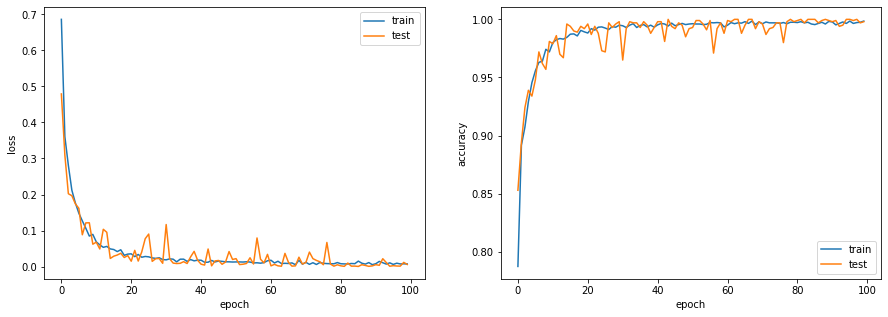


Inception-ResNetV2

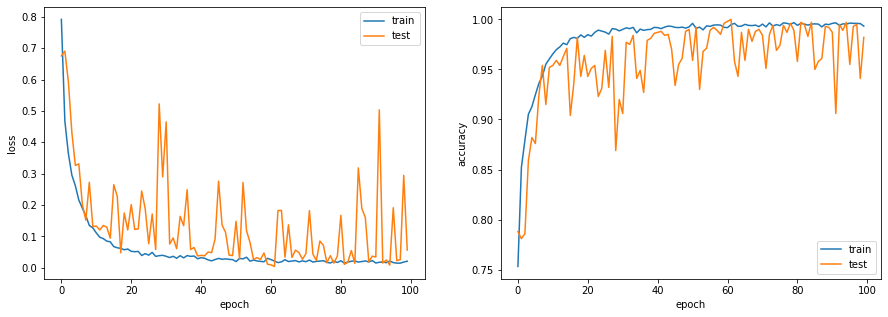

ResNet152

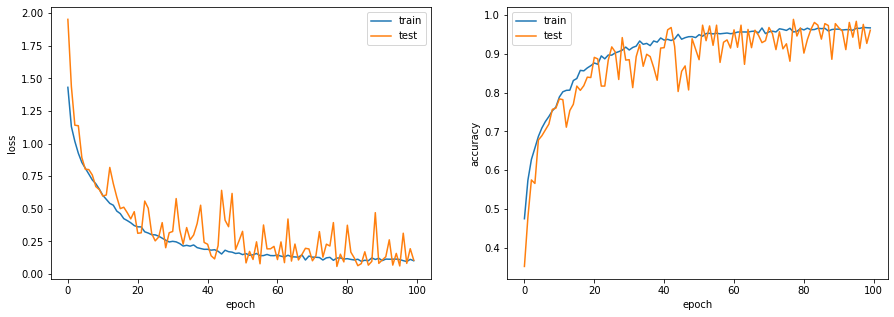


NASNetMobile

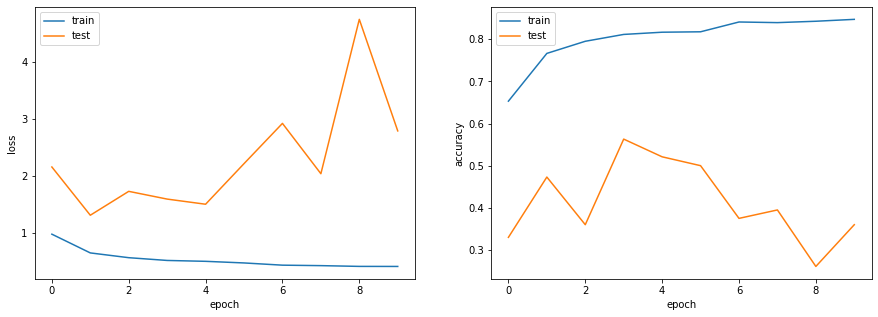

**• Visualization of other models:**

Xception

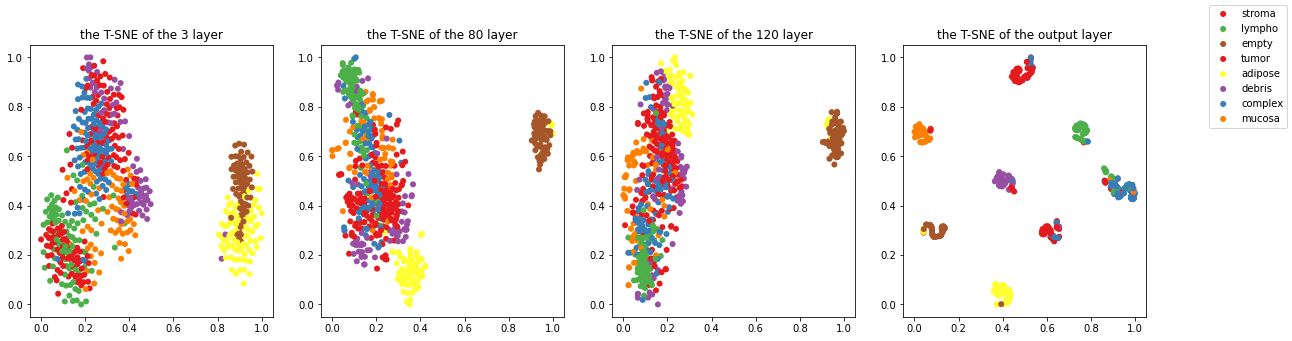


Inception-ResNetV2

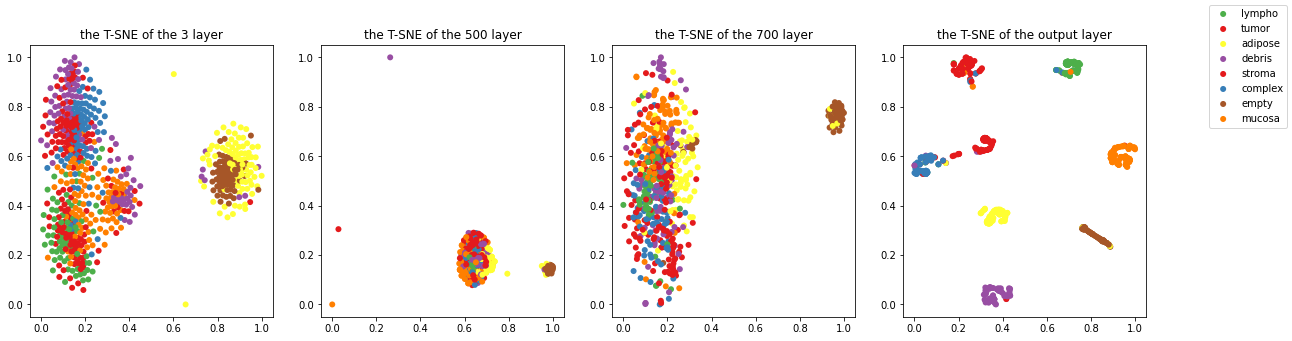

ResNet152

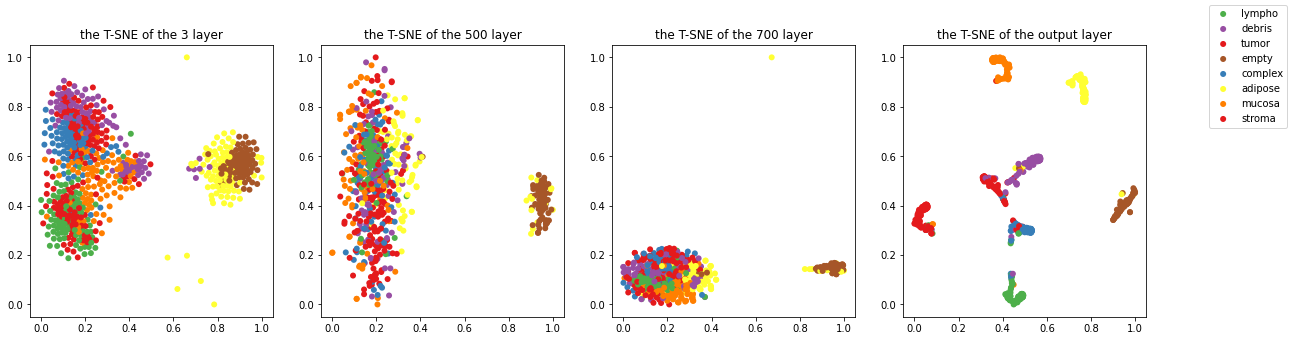

NASNetMobile





---



---

